In [1]:
import mne
import pyedflib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
patient_code = "chb01"
filename = "chb01_04.edf"

In [3]:
filepath = './dataset/patients/chb01/chb01_04.edf'
f = pyedflib.EdfReader(filepath)
n = f.signals_in_file
signal_labels = f.getSignalLabels()
sigbufs = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
    sigbufs[i, :] = f.readSignal(i)

ch_names = f.getSignalLabels()
ch_freqs = f.getSampleFrequencies()
f.close()

In [5]:
# sampling frequency 
fs = ch_freqs[0]
fs

256

In [6]:
info = mne.create_info(ch_names, sfreq=fs, ch_types='eeg')
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: FP1-F7, F7-T7, T7-P7, P7-O1, FP1-F3, F3-C3, C3-P3, P3-O1, ...
 chs: 23 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 23
 projs: []
 sfreq: 256.0 Hz
>


/var/folders/xb/h53k7r3j5_55k9r3s9dzr_tr0000gn/T/ipykernel_33805/1820964546.py:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  info = mne.create_info(ch_names, sfreq=fs, ch_types='eeg')


In [7]:
# convert from microvolt to volt.
# this is because EEG is measured in microvolt
# but mne wants its input EEG signal in volts
fun = lambda x: x/1e+6
data = fun(sigbufs)

In [8]:
raw = mne.io.RawArray(data, info)

Creating RawArray with float64 data, n_channels=23, n_times=921600
    Range : 0 ... 921599 =      0.000 ...  3599.996 secs
Ready.


In [9]:
# set seizure annotation
start_time = np.array([1467.0])
anno_len = 27.0
event_desc = 'Seizure'
raw.set_annotations(mne.Annotations(start_time, anno_len, event_desc))
print(event_desc + " annotation added")

Seizure annotation added


In [10]:
# set plot parameters
plot_kwargs = {
    'scalings': dict(eeg=20e-5),   # zooms the plot out
}


Using matplotlib as 2D backend.


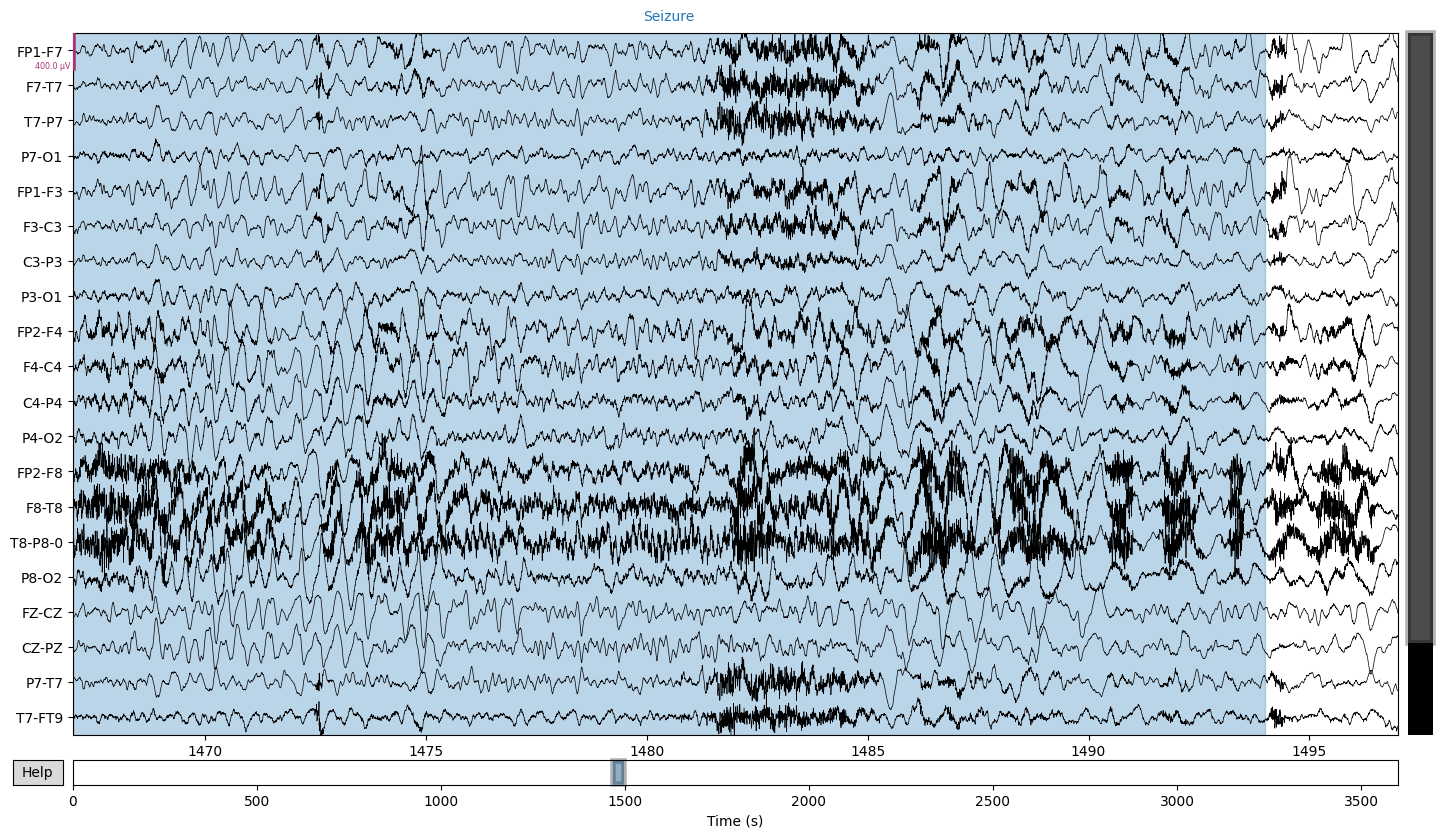

In [11]:
# plot seizure
# start: 1467s, end: 1494s
plot = raw.plot(start=1467.0, duration=30.0, title="chb01_04.edf", **plot_kwargs)

In [12]:
# F8-T8 exhibits fast rhythmic activity during seizure.
# select this channel
idxes = raw.time_as_index([1467, 1494])
print(idxes)
picked = raw.get_data('F8-T8', start=idxes[0], stop=idxes[1])
print(type(picked))
print(picked.shape)

[375552 382464]
<class 'numpy.ndarray'>
(1, 6912)


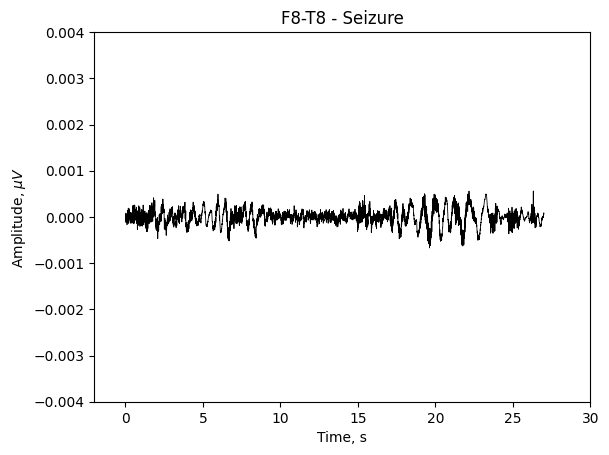

In [18]:
# plot this channel
ch = picked.T
N = len(ch)
t = np.arange(0, N) / fs
fig, ax = plt.subplots()
ax.plot(t, ch, color='k', linewidth=.6)
ax.set_title('F8-T8 - Seizure')
ax.set_xlabel('Time, s')
ax.set_ylabel('Amplitude, $\mu V$')
ax.set_xlim([-2,30])
ax.set_ylim([-0.004, 0.004])
plt.show()

In [19]:
ch = ch.reshape(-1,)

In [20]:
ch.shape

(6912,)

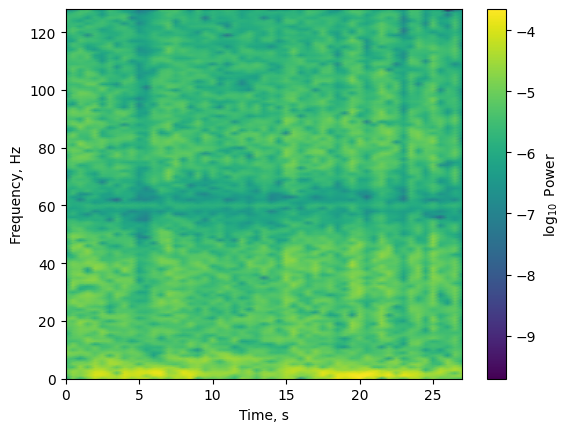

In [21]:
# produce spectrogram of the 30s seizure period using
# STFT with 1s sliding Hann window.
timewin = 1 # in seconds
timewinidx = np.round(timewin/(1/fs)).astype(int)

f, t, Zxx = signal.stft(ch, fs=fs, window='hann', 
                        nperseg=timewinidx, noverlap=None, nfft=None,
                        detrend='linear', return_onesided=True)

fig, ax = plt.subplots()
mesh = ax.pcolormesh(t, f, np.log10(np.abs(Zxx)), shading='gouraud')
ax.set_xlabel('Time, s')
ax.set_ylabel('Frequency, Hz')
cbar = fig.colorbar(mesh)
cbar.ax.set_ylabel('$\log_{10}$ Power')
plt.show()

In [22]:
ch.shape

(6912,)

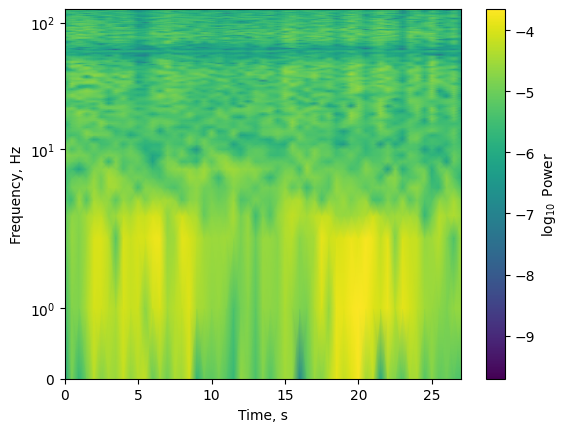

In [25]:
# produce spectrogram of the 30s seizure period using
# STFT with 1s sliding Hann window.
timewin = 1 # in seconds
timewinidx = np.round(timewin/(1/fs)).astype(int)

f, t, Zxx = signal.stft(ch, fs=fs, window='hann', 
                        nperseg=timewinidx, noverlap=None, nfft=None,
                        detrend='linear', return_onesided=True)

fig, ax = plt.subplots()
mesh = ax.pcolormesh(t, f, np.log10(np.abs(Zxx)), shading='gouraud')
ax.set_xlabel('Time, s')
ax.set_ylabel('Frequency, Hz')
ax.set_yscale('symlog')
# ax.set_ylim([np.min(f) + 1, np.max(f)])
cbar = fig.colorbar(mesh)
cbar.ax.set_ylabel('$\log_{10}$ Power')
plt.show()
